In [1]:
from jaxdf.geometry import Domain
from jaxdf.operators import *
from jax import numpy as jnp
from jax import random
from jax.example_libraries import optimizers
from jax.scipy.sparse.linalg import gmres
import jax
from tqdm import tqdm

In [2]:
# Settings
domain = Domain(N=(256, 256), dx=(1., 1.))
seed = jax.random.PRNGKey(42)

# Funcs and operators
def pml_absorption(x):
    alpha = 2.
    sigma_star = 1.
    delta_pml = 100.
    L_half = 128.
    
    abs_x = jnp.abs(x)
    in_pml_amplitude = (jnp.abs(abs_x-delta_pml)/(L_half - delta_pml))**alpha
    return jnp.where(abs_x > delta_pml, sigma_star*in_pml_amplitude, 0.)

def gamma(x, omega=1.):
    y = compose(x)(pml_absorption)
    return 1./(1. + 1j*y/omega)

def mod_laplacian(u, pml):
    # Turning off Nyquist correction, see https://math.mit.edu/~stevenj/fft-deriv.pdf
    grad_u = gradient(u, correct_nyquist=False)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = diag_jacobian(mod_grad_u, correct_nyquist=False)*pml
    return sum_over_dims(mod_diag_jacobian)

@jax.jit
def helmholtz(u, c, pml, omega=1.):
    # Get the modified laplacian
    L = mod_laplacian(u, pml)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u    
    return L + k

@jax.jit
def total_variation(u):
    nabla_u = laplacian(u)
    absval = compose(nabla_u)(jnp.abs)
    return jnp.mean(absval.on_grid)

# Field parameters
x = Continuous(None, domain, lambda p, x: x)
pml = gamma(x)

pml_on_grid = pml.on_grid
zero_params = jnp.zeros((256,256,1)) + 0j
src_params = zero_params.at[128,64].set(1.0)

# Defining fields
u = FourierSeries(zero_params, domain)
pml = FourierSeries(pml_on_grid, domain)
c =  FourierSeries(zero_params, domain)
src = FourierSeries(src_params, domain)

In [3]:
# Those are the parameters we want to optimize
lens_params = random.uniform(seed, (168,40))-4

# Wrap Helmholtz operator around a function to work with GMRES
def helm_func(u):
    return helmholtz(u, c, pml)

def get_sos(T):
    lens = jnp.zeros(domain.N)
    lens = lens.at[44:212,108:148].set(jax.nn.sigmoid(T)) + 1
    return FourierSeries(jnp.expand_dims(lens, -1), domain)

def find_field(c, x0):
    def helm_func(u):
        return helmholtz(u, c, pml, 0.5)
    sol, _ = gmres(helm_func, src, x0=x0, maxiter=1000, tol=1e-4, restart=10)
    return sol

def loss(p, guess):
    sos = get_sos(p)
    tv_term = total_variation(sos)
    field = find_field(sos, x0=guess)
    target_val = field.on_grid[70,210,0]
    return (-jnp.abs(target_val)) + 1e-4*tv_term, field

In [4]:
from jax import jit

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(lens_params)

@jit
def update(opt_state, field):
    loss_and_field, gradient = jax.value_and_grad(loss, has_aux=True)(get_params(opt_state), field)
    return loss_and_field[0], loss_and_field[1], update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
field = -src
for k in pbar:
    lossval, field, opt_state = update(opt_state, field)
    # For logging
    pbar.set_description("Ampl: {:01.4f}".format(-lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Ampl: 0.1340: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:05<00:00,  3.05s/it]


(-0.5, 39.5, 167.5, -0.5)

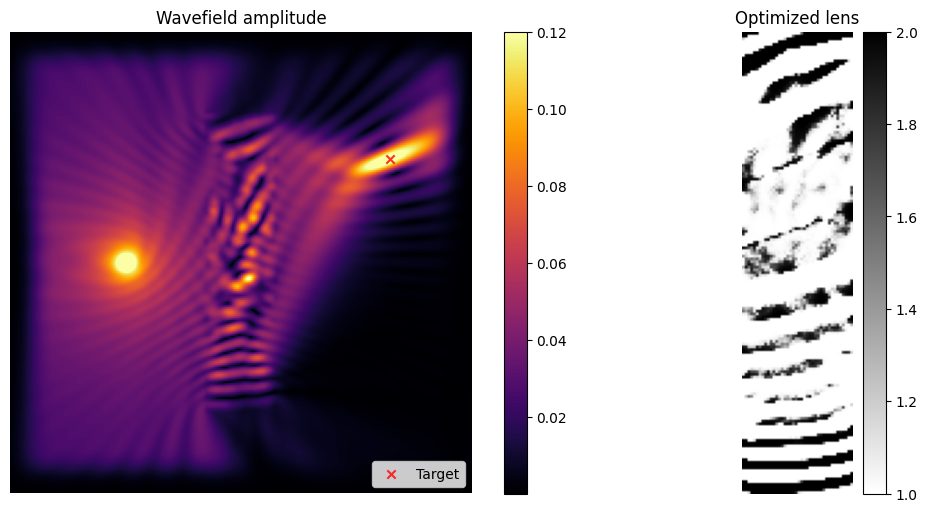

In [7]:
from matplotlib import pyplot as plt

optimal_field = field
sos_opt = get_sos(get_params(opt_state))
tv_sos = total_variation(sos_opt)

fig, ax = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [3, 1]})

im1 = ax[0].imshow(jnp.abs(optimal_field.on_grid), cmap="inferno", vmax=.12)
ax[0].axis("off")
ax[0].scatter(210,70, marker='x', color="red", label="Target", alpha=0.8)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title("Wavefield amplitude")
ax[0].legend(loc="lower right")

sos_opt = get_sos(get_params(opt_state)).on_grid
im2 = ax[1].imshow(sos_opt[44:212,108:148], cmap="binary", vmin=1, vmax=2)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title("Optimized lens")
ax[1].axis("off")